# Import Electrification Study Loads from Snowflake to Python

This is an example notebook to show how to download data from Snowflake

In [1]:
import pandas as pd
import snowflake.connector

This is a general function that helps to query Snowflake.  

In [2]:
def query_snowflake(sfuser, sfpass, sql_query):
    """
    Connects to a Snowflake database and executes a SQL query.

    Parameters:
    - sfuser (str): Snowflake user name for database connection.
    - sfpass (str): Snowflake password for database connection.
    - sql_query (str): SQL query to execute.

    Returns:
    - pandas.DataFrame: A DataFrame containing the query results.
    """

    # Establish connection
    conn = snowflake.connector.connect(
        user=sfuser,
        password=sfpass,
        account='tacoma',
        warehouse='ANALYSTS_WH',
        database='PWR_RAW',
        role='ANALYST',
        schema='EV'
    )

    try:
        cursor = conn.cursor()
        cursor.execute(sql_query)
        rows = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description]
        df = pd.DataFrame(rows, columns=column_names)
    finally:
        cursor.close()
        conn.close()

    return df


This function helps to process the datetime column from Snowflake.  

In [3]:
def process_sf_datetime(df, dt_col = 'TIMESTAMP_HOURLY'):
    """
    Adjusts the datetime in the DataFrame to 'America/Los_Angeles' timezone.

    Parameters:
    - df (pandas.DataFrame): DataFrame with a 'timestamp_hourly' column that needs timezone adjustment.

    Returns:
    - pandas.DataFrame: DataFrame with adjusted datetime index.
    """
    df.rename(columns={dt_col: 'dt'}, inplace=True)
    df.set_index('dt', inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize('UTC')
    df = df.sort_index()
    df['dt'] = df.index + pd.Timedelta(hours=+8)
    df = df.set_index('dt').tz_convert('America/Los_Angeles')

    return df


This a function that makes a query specific to the electrification study.  

In [4]:
def get_hourly_load_adders_query_string(scenario):
    """
    Constructs the SQL query for aggregating hourly MWh data, excluding specific types,
    and calls `query_snowflake` to execute the query.

    Parameters:
    - scenario (str): The adoption scenario to filter data by.

    Returns:
    - pandas.DataFrame: DataFrame returned by `query_snowflake`, ready for further processing.
    """
    sql_query = f'''
        SELECT
            date_trunc('hour', timestamp) as timestamp_hourly,
            SUM(MWH) as total_MWh
        FROM
            pwr_raw.ev.cadeo_load_impacts_feeder AS t1
        JOIN
            pwr_raw.ev.cadeo_measure_load_impact_segments AS t2 ON t1.seg_code = t2.data_output
        WHERE
            adoption_scenario='{scenario}'
            AND TYPE NOT IN ('Building Energy Efficiency', 'Demand Response')
        GROUP BY
            timestamp_hourly
        ORDER BY
            timestamp_hourly
    '''

    return sql_query


Run the query.  This was lase run with my user and password included which have been deleted.  

<Axes: xlabel='dt'>

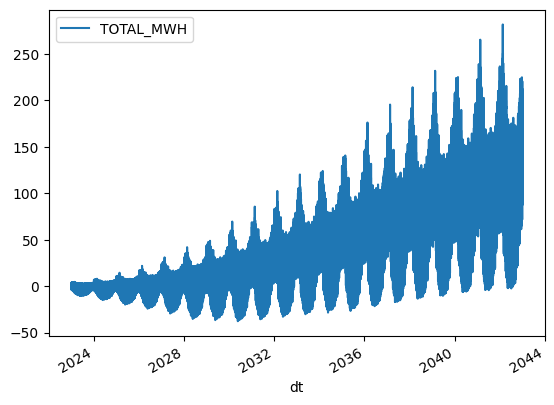

In [5]:
scenario = 'scenario_2'
sfuser = 'xxx'
sfpass = 'xxx'
df = process_sf_datetime(query_snowflake(sfuser, sfpass, get_hourly_load_adders_query_string(scenario)))
df.plot()